## Импорт библиотек

In [ ]:
!unzip '95cloud-cloud-segmentation-on-satellite-images.zip'

In [1]:
import numpy as np
print(np.__version__)

import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)
from fastai.vision.all import *

import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import albumentations as A
import pdb

2.0.2
2.5.1+cpu
False
2.7.18


In [2]:
def open_tif(fn, chnls=None, cls=torch.Tensor):
    im = (np.array(Image.open(fn))).astype('float32')
    return cls(im)

# Функция map_filename упрощает отображение из одной папки в другую путем замены строк
def map_filename(base_fn, str1, str2):
    return Path(str(base_fn).replace(str1, str2))

def get_filenames(red_filename):
    return [red_filename,
            map_filename(red_filename, str1='red', str2='green'),
            map_filename(red_filename, str1='red', str2='blue'),
            map_filename(red_filename, str1='red', str2='nir'),
           ]

# функция open multispectral tif будет отвечать за открытие отдельных tiff-файлов и их сопоставление
def open_ms_tif(files):
    ms_img = None

    for path in files:
        img = open_tif(path)

        if ms_img is None:
            ms_img = img[None]
        else:
            ms_img = np.concatenate([ms_img, img[None]], axis=0)

    return TensorImage(ms_img)

In [3]:
# Проверка функции
base_path = Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud')

print(open_tif(base_path/'red_patch_100_5_by_16_LC08_L1TP_035031_20160120_20170224_01_T1.TIF').shape)

items = get_files(base_path, extensions='.TIF')

# Проверка работает ли mapping корректно
for path in get_filenames(items[0]):
    assert path.exists() == True

# Проверка открытия изображений
open_ms_tif(get_filenames(items[0])).shape

torch.Size([384, 384])


torch.Size([4, 384, 384])

In [4]:
# Выберем только не пустые сцены исходя из csv списка приложенного к датасету
items_95 = get_files('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud', extensions='.TIF')
n_empty = pd.read_csv('95-cloud_training_only_additional_to38-cloud/training_patches_95-cloud_nonempty.csv')

def non_empty(item):

    if n_empty.name.isin([item.stem[4:]]).any():
        return True
    else:
        return False

items_mask = items_95.map(non_empty)
items = items_95[items_mask]
items

(#16347) [Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_044017_20160220_20170224_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_047011_20160920_20170221_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_047017_20160920_20170221_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_047019_20160920_20170221_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_048016_20160420_20170223_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/re

torch.Size([4, 384, 384]) torch.Size([384, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

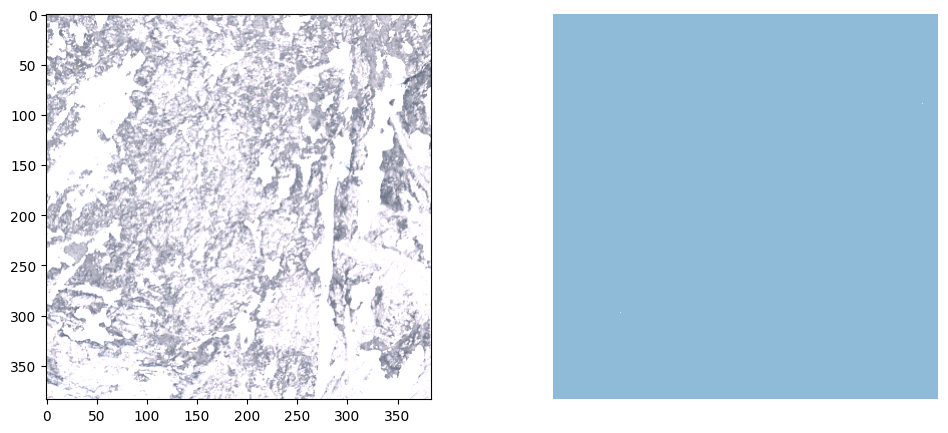

In [5]:
idx=5
img_pipe = Pipeline([get_filenames, open_ms_tif])
img = img_pipe(items[idx])

mask_pipe = Pipeline([partial(map_filename, str1='red', str2='gt'),
                      partial(open_tif, cls=TensorMask)])

mask = mask_pipe(items[idx])
print(img.shape, mask.shape)

_, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow(img.permute(1, 2, 0)[..., :3]/20000)
mask.show(ctx=ax[1])

In [8]:
# Посчитаем процентное соотношение файлов с облаками и пикселей облаков на изображении
count = 0
count_pixel = 0
for i in range(len(items)):
    mask = (mask_pipe(items[i]))
    if mask.max() == 255: count+=1
    mask = np.array(mask)
    count_pixel+=np.count_nonzero(mask == 255)

total_pixel = 384*384*len(items)
print(f'Total images: {len(items)}')
print(f'Images with clouds: {count} ({count/len(items)*100:.2f}%)')
print(f'Total pixels: {total_pixel}')
print(f'Cloud pixels: {count_pixel} ({count_pixel/total_pixel*100:.2f}%)')

Total images: 16347
Images with clouds: 12258 (74.99%)
Total pixels: 2410463232
Cloud pixels: 1058202919 (43.90%)


## Аугментация

In [6]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug, **kwargs):
        super().__init__(**kwargs)
        self.aug = aug

    def encodes(self, x):
        img,mask = x

        img = img/img.max()

        # for albumentations to work correctly, the channels must be at the last dimension
        aug = self.aug(image=np.array(img.permute(1,2,0)), mask=np.array(mask))
        return TensorImage(aug['image'].transpose(2,0,1)), TensorMask(aug['mask'])

# Организуем последовательность изменений
aug_pipe = A.Compose([A.ShiftScaleRotate(p=.9),
                      A.HorizontalFlip(),
                      A.RandomBrightnessContrast(contrast_limit=0.0, p=1., brightness_by_max=False)])

# Создадим класс аугментации для дальнейшей передачи в модель
aug = SegmentationAlbumentationsTransform(aug_pipe)

## Создание DataSet DataLoader

In [7]:
# Функция для отображения
def show_img(tensor_img, ctx=None):
    ctx = plt.subplot() if ctx is None else ctx

    # Нормалзуем данные от 0 до 1
    if tensor_img.max() > 0:
        tensor_img = tensor_img / tensor_img.max()

    ctx.imshow(tensor_img.permute(1, 2, 0)[..., :3])

In [8]:
ImageBlock = TransformBlock(
    type_tfms = [get_filenames, open_ms_tif, lambda x: x/10000])

MaskBlock = TransformBlock(
    type_tfms = [partial(open_tif, cls=TensorMask), AddMaskCodes(codes=['clear', 'cloudy'])])

db = DataBlock(blocks=(ImageBlock, MaskBlock),
               get_y = partial(map_filename, str1='red', str2='gt'),
               splitter=RandomSplitter(valid_pct=0.2),
               item_tfms=aug
              )

# Мы вызовем db.summary, чтобы посмотреть, все ли идет хорошо
# окончательный образец состоит из кортежа (X, Y)
%time db.summary(source=items)

Setting-up type transforms pipelines
Found 16347 items
2 datasets of sizes 13078,3269
Setting up Pipeline: get_filenames -> open_ms_tif -> <lambda>
Setting up Pipeline: partial -> partial -> AddMaskCodes

Building one sample
  Pipeline: get_filenames -> open_ms_tif -> <lambda>
    starting from
      95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_314_15_by_6_LC08_L1TP_047017_20160920_20170221_01_T1.TIF
    applying get_filenames gives
      [95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_314_15_by_6_LC08_L1TP_047017_20160920_20170221_01_T1.TIF, 95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud/green_patch_314_15_by_6_LC08_L1TP_047017_20160920_20170221_01_T1.TIF, 95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud/blue_patch_314_15_by_6_LC08_L1TP_047017_20160920_20170221_01_T1.TIF, 95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/n

In [9]:
dl = db.dataloaders(source=items, bs=8, num_workers=0)

# проверим был ли создан batch корректно
batch = dl.one_batch()
batch[0].shape, batch[1].shape

(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

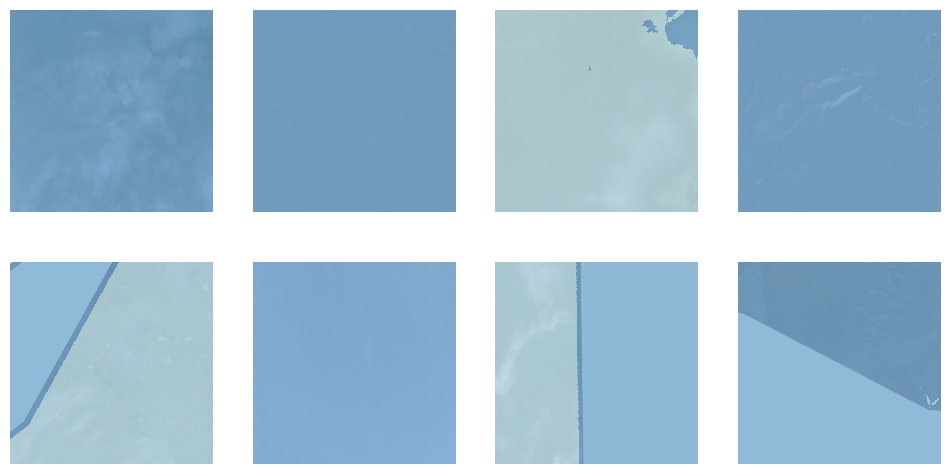

In [11]:
dl.show_batch(max_n=9)

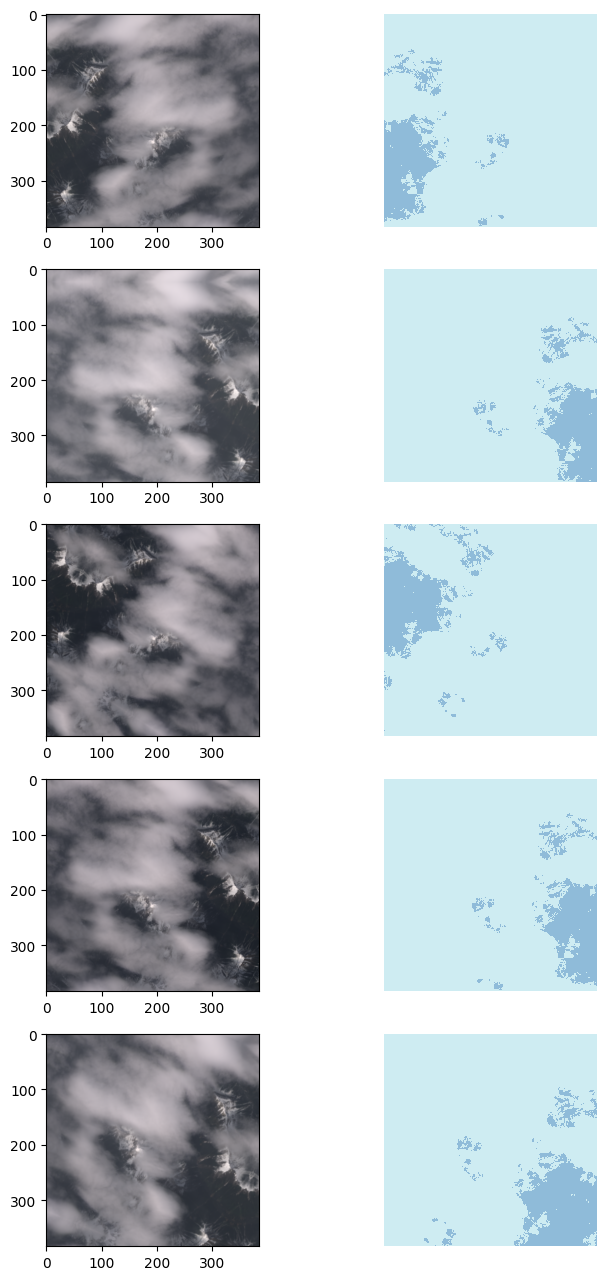

In [10]:
# Проверим работу аугментации
idx = 7
aug_number = 4

# Выведем оригинальное и несколько измененных изображений
_, ax = plt.subplots(aug_number+1, 2, figsize=(8,aug_number*4))

ds = db.datasets(source=items)

show_img(ds[idx][0], ctx=ax[0,0])
ds[idx][1].show(ctx=ax[0,1])

for i in range(1, aug_number+1):
    img, mask = aug.encodes(ds[idx])
    show_img(img, ctx=ax[i,0])
    mask.show(ctx=ax[i,1])

## Обучение модели

In [10]:
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def loss_fn(pred, targ):
    targ[targ==255] = 1
    return torch.nn.functional.cross_entropy(pred, targ.squeeze(1).type(torch.long))

learn_resnet34 = unet_learner(dl, resnet34, n_in=4, n_out=2, pretrained=False, loss_func=loss_fn, metrics=acc_metric)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
learn_resnet34.summary()

DynamicUnet (Input shape: 8 x 4 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 192 x 192  
Conv2d                                    12544      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 96 x 96    
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     8 x 256 x 96 x 96   
Conv2d                                    16384      True      
BatchNorm2d                        

SuggestedLRs(valley=0.0003981071640737355)

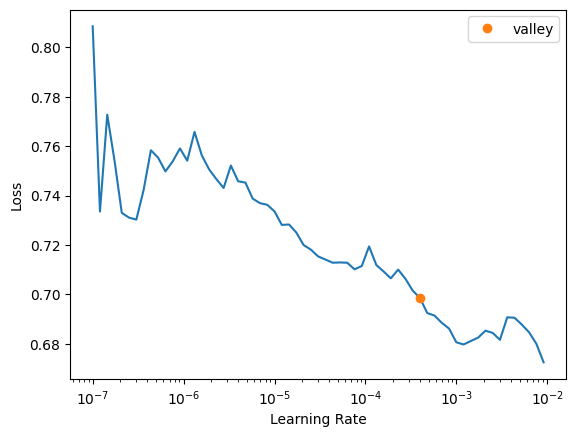

In [11]:
learn_resnet34.lr_find()

In [10]:
learn_resnet34.fit_one_cycle(20, lr_max=1e-4, wd=1e-2)

train_loss  valid_loss  acc_metric   time
0     0.444016    0.396385    0.819773  37:26
1     0.423204    0.375103    0.840623  37:25
2     0.386949    0.501062    0.759853  37:25
3     0.357371    0.444049    0.790872  37:16
4     0.333500    0.390998    0.833637  37:12
5     0.308275    0.354004    0.828990  36:57
6     0.293624    0.312067    0.869195  36:51
7     0.256049    0.272125    0.878424  37:03
8     0.233143    0.224719    0.904411  36:53
9     0.200866    0.205925    0.880731  36:23
10    0.153176    0.148802    0.895895  35:53
11    0.106067    0.129847    0.916519  35:44
12    0.128792    0.104657    0.906177  36:22
13    0.098228    0.084758    0.922736  37:19
14    0.084181    0.096245    0.938676  36:52
15    0.088128    0.099638    0.943366  36:44
16    0.079149    0.099029    0.945739  36:25
17    0.073357    0.086270    0.946893  36:22
18    0.079240    0.081814    0.958103  36:41
19    0.071101    0.089870    0.957851  36:46

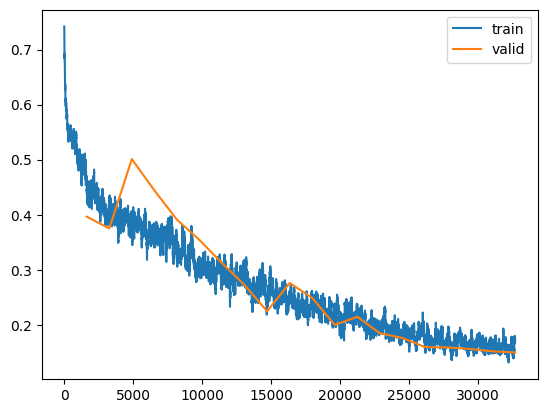

In [13]:
learn_resnet34.recorder.plot_loss()

In [14]:
# Сохраним модель
learn_resnet34.save('./resnet34-2.learner')

Path('models/resnet34-2.learner.pth')